In [ ]:
# set visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [1]:
# set the cwd to the root of the repo

import os
# change dir to root of repo
os.chdir('..')

import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import plotly.graph_objects as go
from torch.utils.data import Dataset

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.models.reni_neus import RENINeuSModel, RENINeuSModelConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames
from nerfstudio.fields.reni_field import get_directions
from nerfstudio.fields.reni_field import RENIField, get_directions, get_sineweight
from nerfstudio.cameras.rays import RayBundle
from nerfstudio.utils.images import BasicImages

def make_ray_bundle_clone(ray_bundle):
    new_ray_bundle = RayBundle(
      origins=ray_bundle.origins.detach().clone(),
      directions=ray_bundle.directions.detach().clone(),
      pixel_area=ray_bundle.pixel_area.detach().clone(),
      directions_norm=ray_bundle.directions_norm.detach().clone(),
      camera_indices=ray_bundle.camera_indices.detach().clone(),
      nears=ray_bundle.nears.detach().clone() if ray_bundle.nears is not None else None,
      fars=ray_bundle.fars.detach().clone() if ray_bundle.fars is not None else None,
    )
    return new_ray_bundle

def make_batch_clone(batch):
    new_batch = {}
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            new_batch[key] = value.detach().clone()
        else:
            new_batch[key] = value
    return new_batch       

def sRGB(imgs):
    # if shape is not B, C, H, W, then add batch dimension
    if len(imgs.shape) == 3:
        imgs = imgs.unsqueeze(0)
    q = torch.quantile(torch.quantile(torch.quantile(imgs, 0.98, dim=(1)), 0.98, dim=(1)), 0.98, dim=(1))
    imgs = imgs / q.unsqueeze(1).unsqueeze(2).unsqueeze(3)
    imgs = torch.clamp(imgs, 0.0, 1.0)
    imgs = torch.where(
        imgs <= 0.0031308,
        12.92 * imgs,
        1.055 * torch.pow(torch.abs(imgs), 1 / 2.4) - 0.055,
    )
    return imgs

def rotation_matrix(axis, angle):
    """
    Return 3D rotation matrix for rotating around the given axis by the given angle.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

ckpt_path = 'outputs/data-NeRF-OSR-Data/RENI-NeuS/latest_with_rot_and_clip_illumination/'
step = 80000

ckpt = torch.load(ckpt_path + '/sdfstudio_models' + f'/step-{step:09d}.ckpt', map_location=device)
model_dict = {}
for key in ckpt['pipeline'].keys():
    if key.startswith('_model.'):
        model_dict[key[7:]] = ckpt['pipeline'][key]

# load yaml checkpoint config
config_path = Path(ckpt_path) / 'config.yml'
config = yaml.load(config_path.open(), Loader=yaml.Loader)

pipeline_config = config.pipeline
pipeline_config.datamanager.dataparser.scene = 'lk2'
pipeline_config.datamanager.dataparser.use_session_data = False

# if illumination_sampler_random_rotation not in pipeline.config.model add it and set to false
try:
    pipeline_config.model.illumination_sampler_random_rotation
except AttributeError:
    pipeline_config.model.illumination_sampler_random_rotation = True
try:
    pipeline_config.model.illumination_sample_remove_lower_hemisphere
except AttributeError:
    pipeline_config.model.illumination_sample_remove_lower_hemisphere = True

datamanager: VanillaDataManager = pipeline_config.datamanager.setup(
    device=device, test_mode=test_mode, world_size=world_size, local_rank=local_rank, 
)
datamanager.to(device)
# includes num_eval_data as needed for reni latent code fitting.
model = pipeline_config.model.setup(
    scene_box=datamanager.train_dataset.scene_box,
    num_train_data=len(datamanager.train_dataset),
    num_eval_data=len(datamanager.eval_dataset),
    metadata=datamanager.train_dataset.metadata,
    world_size=world_size,
    local_rank=local_rank,
    eval_latent_optimisation_source=pipeline_config.eval_latent_optimisation_source,
)
model.to(device)

model.load_state_dict(model_dict)
model.eval()

image_idx_original = 1
camera_ray_bundle_original, batch_original = datamanager.eval_dataloader.get_data_from_image_idx(image_idx_original)
if isinstance(batch_original["image"], BasicImages):
    batch_original["image"] = batch_original["image"].images[0]
    camera_ray_bundle_original = camera_ray_bundle_original.reshape((*batch_original["image"].shape[:-1], 1))

True # printing to hide long cell output

Loading data batch ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

True

mlp($\hat{x}, d$) where $x = \hat{x}r$

$||x|| = ||d|| = 1$

Losses:

1. DDF->SDF Level Set 
2. Ray Hit Probability Supervision -> SDF Accumulation 
3. SDF Expected Termination Supervisioni -> SDF Accumulation
4. Multiview consitancy -> other point on sphere $x_{2}$ looking at same point must have $f_{\text{DDF}} <= 


Now we need to generate a lot of random positions on a unit sphere and directions but directions need to be only in the hemisphere of the inward facing normal from the point on the sphere.

In [2]:
def random_points_on_unit_sphere(num_points, cartesian=False):
    theta = 2 * torch.pi * torch.rand(num_points)
    phi = torch.acos(2 * torch.rand(num_points) - 1)
    if cartesian:
        return torch.stack(sph2cart(theta, phi), dim=1)
    return torch.stack([theta, phi], dim=1)

def random_inward_facing_directions(num_directions, normals):
    # num_directions = scalar
    # normals = (N, 3)
    # returns (N, num_directions, 3)

    # For each normal get a random set of directions
    directions = random_points_on_unit_sphere(num_directions * normals.shape[0], cartesian=True)
    directions = directions.reshape(normals.shape[0], num_directions, 3)

    # remove any directions that are not in the hemisphere of the associated normal
    dot_products = torch.sum(normals.unsqueeze(1) * directions, dim=2)
    mask = dot_products < 0

    # negate the directions that are not in the hemisphere
    directions[mask] = -directions[mask]

    return directions    

def sph2cart(theta, phi):
    x = torch.sin(phi) * torch.cos(theta)
    y = torch.sin(phi) * torch.sin(theta)
    z = torch.cos(phi)
    return x, y, z

def cart2sph(x, y, z):
    r = torch.sqrt(x**2 + y**2 + z**2)
    theta = torch.atan2(y, x)
    phi = torch.acos(z / r)
    return theta, phi

def look_at_target(camera_position, target_position, up_vector=torch.tensor([0.0, 0.0, 1.0])):
    def normalize(vector):
        return vector / torch.norm(vector)
    
    forward_vector = -normalize(target_position - camera_position)
    
    right_vector = normalize(torch.cross(up_vector, forward_vector))
    
    actual_up_vector = normalize(torch.cross(forward_vector, right_vector))
    
    c2w_matrix = torch.zeros(4, 4)
    c2w_matrix[:3, 0] = right_vector
    c2w_matrix[:3, 1] = actual_up_vector
    c2w_matrix[:3, 2] = forward_vector
    c2w_matrix[:3, 3] = camera_position
    c2w_matrix[3, 3] = 1.0
    
    return c2w_matrix

class DDFSDFDataset(Dataset):
    def __init__(self, num_directions, ddf_sphere_radius, sdf_function, repeat_position, device):
        self.sdf_function = sdf_function
        self.ddf_sphere_radius = ddf_sphere_radius
        self.num_directions = num_directions
        self.repeat_position = repeat_position
        self.device = device
        # generate a H and W from number of directions
        self.H, self.W = self._find_factors(self.num_directions)[-1]

        origins = torch.zeros(self.H, self.W, 1, 3, device=device)
        directions = torch.ones(self.H, self.W, 1, 3, device=device)
        pixel_area = torch.ones(self.H, self.W, 1, 1, device=device)
        directions_norm = torch.ones(self.H, self.W, 1, 1, device=device)
        # camera indices should be int64
        camera_indices = torch.zeros(self.H, self.W, 1, 1, device=device, dtype=torch.int64)
        nears = torch.ones(self.H, self.W, 1, 1, device=device) * sdf_function.scene_box.near
        fars = torch.ones(self.H, self.W, 1, 1, device=device) * sdf_function.scene_box.far

        self.ray_bundle = RayBundle(
                              origins=origins,
                              directions=directions,
                              pixel_area=pixel_area,
                              directions_norm=directions_norm,
                              camera_indices=camera_indices,
                              nears=nears,
                              fars=fars
                          )

    def __len__(self):
        return self.num_positions
    
    def _find_factors(self, value):
      factors = []
      for i in range(2, int(value**0.5) + 1):
          if value % i == 0:
              factors.append((i, value // i))
      return factors

    def _generate_sample(self):
        if self.repeat_position:
            positions = torch.tensor([[0.6421, 0.7197, -0.2640]])
            positions = positions / torch.norm(positions)
        else:
            positions = random_points_on_unit_sphere(1, cartesian=True) # (1, 3)

        directions = random_inward_facing_directions(self.num_directions, normals=-positions) # (1, num_directions, 3)
        
        # scale positions from unit sphere to ddf_sphere_radius
        positions = positions * self.ddf_sphere_radius
        
        pos_ray = positions.unsqueeze(1).unsqueeze(1).expand(self.H, self.W, 1, -1).to(self.device)
        dir_ray = directions.reshape(self.H, self.W, 3).unsqueeze(2).to(self.device)

        self.ray_bundle.origins = pos_ray
        self.ray_bundle.directions = dir_ray
        field_outputs = self.sdf_function.get_outputs_for_camera_ray_bundle(self.ray_bundle)
        accumultation = field_outputs["accumulation"].reshape(-1, 1).squeeze()
        termination_dist = field_outputs["depth"].reshape(-1, 1).squeeze()

        directions = directions.squeeze(0)
        positions = positions.repeat(directions.shape[0], 1)

        return positions, directions, accumultation, termination_dist
        
    def __getitem__(self, idx):
        return self._generate_sample()


Generating output for camera... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 100% 0:00:01

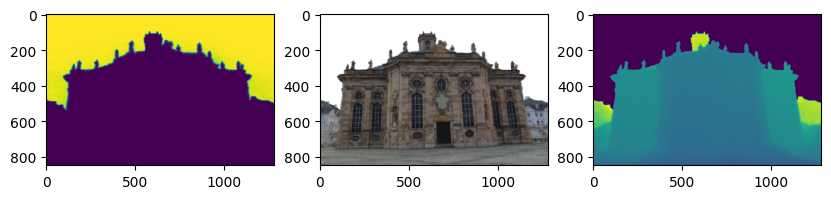

In [3]:
camera_ray_bundle = make_ray_bundle_clone(camera_ray_bundle_original)
batch = make_batch_clone(batch_original)

# set all nears to 0.05
camera_ray_bundle.nears = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.near
# set all fars to 100
camera_ray_bundle.fars = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.far

model.config.eval_num_rays_per_chunk = 2048

outputs = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle, show_progress=True)

accumulation = outputs['accumulation'].cpu().detach().numpy()
visibiltiy = 1.0 - accumulation
rgb = outputs['rgb'].cpu().detach().numpy()
depth = outputs['depth'].cpu().detach().numpy()
depth = depth * (outputs['accumulation'] > 0.7).float().cpu().detach().numpy()

# plot both in the same figure
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(visibiltiy)
ax[1].imshow(rgb)
ax[2].imshow(depth)

So lets test this with just a single frame, looking at the centre of the scene but but on the unit sphere

First generate the data:

In [11]:
# get the c2w matrix of the camera
old_c2w = datamanager.eval_dataloader.cameras[image_idx_original].camera_to_worlds.detach().clone() # [3, 4]
new_pos = old_c2w[:3, 3].detach().clone() # [3]
new_pos[2] = new_pos[2] + 0.07
new_pos = new_pos / torch.norm(new_pos) # on the unit sphere

new_c2w = look_at_target(new_pos.cpu(), torch.tensor([0.0, 0.0, 0.0]))[:3, :4] # [3, 4] # C2W matrix looking at the center of the scene

datamanager.eval_dataloader.cameras.camera_to_worlds[image_idx_original].copy_(new_c2w)

camera_ray_bundle, batch = datamanager.eval_dataloader.get_data_from_image_idx(image_idx_original)
if isinstance(batch["image"], BasicImages):
    batch["image"] = batch["image"].images[0]
    camera_ray_bundle = camera_ray_bundle.reshape((*batch["image"].shape[:-1], 1))

# set all nears to 0.05
camera_ray_bundle.nears = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.near
# set all fars to 100
camera_ray_bundle.fars = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.far

model.config.eval_num_rays_per_chunk = 2048

outputs = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle, show_progress=True)

# set the c2w matrix back to the original one
datamanager.eval_dataloader.cameras.camera_to_worlds[image_idx_original].copy_(old_c2w)

Generating output for camera... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 100% 0:00:01

tensor([[ 0.9907, -0.0118, -0.1355, -0.0879],
        [-0.1336, -0.2737, -0.9525, -0.5683],
        [-0.0259,  0.9618, -0.2727,  0.0014]], device='cuda:0')

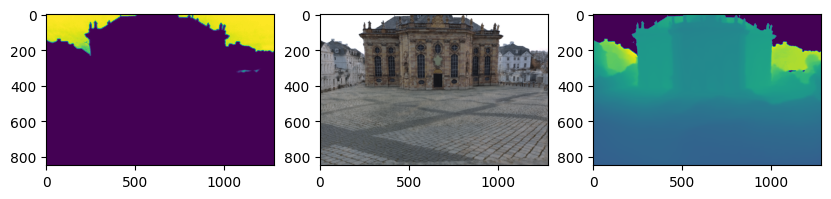

In [12]:
accumulation = outputs['accumulation'].cpu().detach().numpy()
visibiltiy = 1.0 - accumulation
rgb = outputs['rgb'].cpu().detach().numpy()
depth = outputs['depth'].cpu().detach().numpy()
depth = depth * (outputs['accumulation'] > 0.7).float().cpu().detach().numpy()

# plot both in the same figure
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(visibiltiy)
ax[1].imshow(rgb)
ax[2].imshow(depth)

Get positions and directions for each ray in coming from the camera:

In [ ]:
H, W = camera_ray_bundle.origins.shape[:2]

positions = new_pos.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat(H, W, 1, 1).to(device) # [H, W, 1, 3]
positions = positions.reshape(-1, 3) # [N, 3]
directions = camera_ray_bundle.directions # [H, W, 1, 3]
directions = directions.reshape(-1, 3) # [N, 3]
accumulation = outputs['accumulation'].reshape(-1, 1).squeeze() # [N]
termination_dist = outputs['depth'].reshape(-1, 1).squeeze() # [N]

# move data into dictionary and save
data = {
    "H": H,
    "W": W,
    "positions": positions,
    "directions": directions,
    "accumulation": accumulation,
    "termination_dist": termination_dist,
}

torch.save(data, "notebooks/ddf_test_data/single_viewpoint_data.pt")

In [4]:
# Setup DDF Field
from nerfstudio.field_components.encodings import SHEncoding, NeRFEncoding
import tinycudann as tcnn

def get_normalized_tensor(t):
    """SH encoding must be in the range [0, 1]

    Args:
        t: batch of vectors
    """
    return (t + 1.0) / 2.0

position_encoding = SHEncoding(4)
direction_encoding = SHEncoding(4)

position_encoding = NeRFEncoding(
    in_dim=3, num_frequencies=10, min_freq_exp=0.0, max_freq_exp=8.0, include_input=True
)
direction_encoding = NeRFEncoding(
    in_dim=3, num_frequencies=6, min_freq_exp=0.0, max_freq_exp=8.0, include_input=True
)

hidden_dim_ddf = 128
num_layers_ddf = 7
output_dim_ddf = 2 # Scalar distance and probability of termination

ddf = tcnn.Network(
    n_input_dims=6
    + position_encoding.get_out_dim()
    + direction_encoding.get_out_dim(),
    n_output_dims=output_dim_ddf,
    network_config={
        "otype": "FullyFusedMLP",
        "activation": "ReLU",
        "output_activation": "None",
        "n_neurons": hidden_dim_ddf,
        "n_hidden_layers": num_layers_ddf - 1,
    },
)

ddf.to(device)

Network(n_input_dims=108, n_output_dims=2, seed=1337, dtype=torch.float16, hyperparams={'encoding': {'offset': 0.0, 'otype': 'Identity', 'scale': 1.0}, 'network': {'activation': 'ReLU', 'n_hidden_layers': 6, 'n_neurons': 128, 'otype': 'FullyFusedMLP', 'output_activation': 'None'}, 'otype': 'NetworkWithInputEncoding'})

This is testing using a SIREN network

In [20]:
from notebooks.siren import Siren

ddf = Siren(in_features=6, hidden_features=256, hidden_layers=4, out_features=2, outermost_linear=True, first_omega_0=30, hidden_omega_0=30)

ddf.to(device)

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=6, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [24]:
import wandb

# Initialize a new W&B run
wandb.init(project="ddf")

# setup optimizer and training loop
optim = torch.optim.Adam(ddf.parameters(), lr=1e-4)
sdf_loss = torch.nn.MSELoss()
hit_probability_loss = torch.nn.MSELoss()
expected_termination_loss = torch.nn.MSELoss()

epochs = 1500
num_samples = 256
epochs_until_checkpoint = 10

# load data
data = torch.load("notebooks/ddf_test_data/single_viewpoint_data.pt")
H, W = data["H"], data["W"]
positions = data["positions"].to(device)
directions = data["directions"].to(device)
accumulation = data["accumulation"].to(device)
termination_dist = data["termination_dist"].to(device)

for i in tqdm.tqdm(range(epochs)):
    # generate a random batch 
    idx = torch.randperm(positions.shape[0])[:num_samples]
    positions_batch = positions[idx]
    directions_batch = directions[idx]
    accumulation_batch = accumulation[idx]
    termination_dist_batch = termination_dist[idx]

    # encoded_positions = position_encoding(get_normalized_tensor(positions_batch)) # [N, 16]
    # encoded_directions = direction_encoding(get_normalized_tensor(directions_batch)) # [N, 16]
    # encoded_positions = position_encoding(positions_batch) # [N, K]
    # encoded_directions = direction_encoding(directions_batch) # [N, K]
    # model_input = torch.cat([positions_batch, directions_batch, encoded_positions, encoded_directions], dim=-1) # [N, K]

    model_input = torch.cat([positions_batch, directions_batch], dim=-1) # [N, 3 + 3] = [N, 6]

    output = ddf(model_input) # [N, 2]
    output = output.type(torch.float32)
    expected_termination_dist = torch.relu(output[..., 0]) # [N]
    probability_of_hit = torch.sigmoid(output[..., 1]) # We want a probability between 0 and 1 [N]

    # get sdf at termination outputted by the ddf
    sdf_at_termination = model.field.get_sdf_at_pos(positions_batch + directions_batch * expected_termination_dist.unsqueeze(-1)).squeeze() # [N]

    l1 = 1.0 * hit_probability_loss(probability_of_hit, accumulation_batch)

    mask = (accumulation_batch > 0.7).float() # only consider pixels that hit an object when estimating expected termination distance [N]

    l2 = 1.0 * sdf_loss(sdf_at_termination * mask, torch.zeros_like(sdf_at_termination))

    l3 = 3.0 * expected_termination_loss(expected_termination_dist * mask, termination_dist_batch * mask)

    loss = l1 + l2 + l3
    
    optim.zero_grad()
    loss.backward()
    optim.step()

    # save model to wandb folder
    if i % epochs_until_checkpoint == 0:
        torch.save(ddf.state_dict(), os.path.join(wandb.run.dir, "ddf.pt"))

    # Log losses to W&B
    wandb.log({"hit_loss": l1.item(), "sdf_loss": l2.item(), "term_loss": l3.item(), "total_loss": loss.item()})

wandb.finish()

100%|██████████| 1500/1500 [00:24<00:00, 60.27it/s]


hit_loss,█▅▄▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sdf_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
term_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss,█▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
hit_loss,0.00422
sdf_loss,0.00256
term_loss,0.00659
total_loss,0.01337


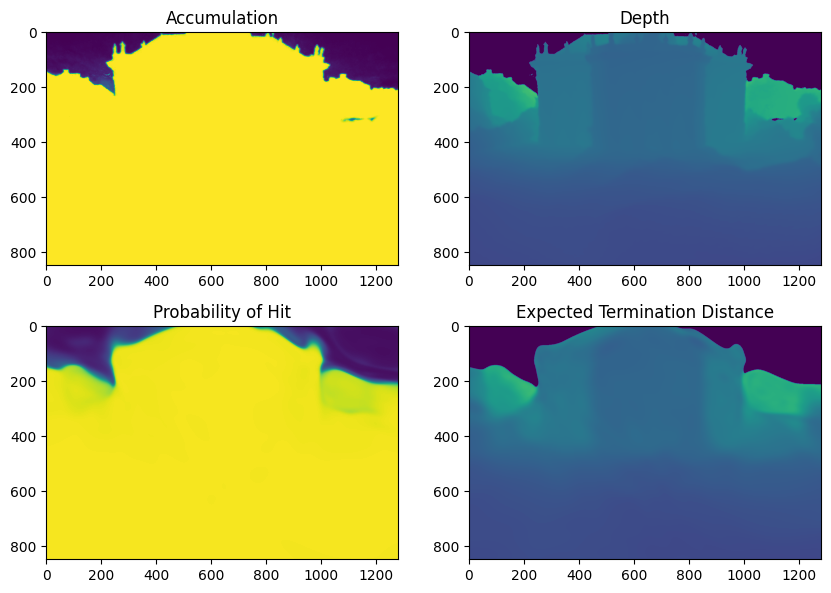

In [27]:
with torch.no_grad():
  accumulation = data['accumulation'].reshape(H, W).cpu().detach().numpy()
  depth = termination_dist.reshape(H, W).cpu().detach().numpy()
  depth = (data['termination_dist'] * (data['accumulation'] > 0.7).float()).reshape(H, W).cpu().detach().numpy()

  # plot everything in the same figure
  fig, ax = plt.subplots(2, 2, figsize=(10, 7))
  # first row is accumulation, rgb, depth
  im1 = ax[0, 0].imshow(accumulation, vmin=0, vmax=1)
  im2 = ax[0, 1].imshow(depth, vmin=0, vmax=3.5)
  # add titles to the first row
  ax[0, 0].set_title("Accumulation")
  ax[0, 1].set_title("Depth")

  encoded_positions = position_encoding(positions) # [N, 16]
  encoded_directions = direction_encoding(directions) # [N, 16]
  model_input = torch.cat([positions, directions, encoded_positions, encoded_directions], dim=-1) # [N, 3 + 3 + 16 + 16] = [N, 38]
  model_input = torch.cat([positions, directions], dim=-1) # [N, 3 + 3] = [N, 6]

  output = ddf(model_input) # [N, 2]
  output = output.type(torch.float32)
  expected_termination_dist = torch.relu(output[..., 0]) # [N]
  probability_of_hit = torch.sigmoid(output[..., 1]) # We want a probability between 0 and 1 [N]

  # second row is probability of hit, blank image and expected termination distance
  im1 = ax[1, 0].imshow(probability_of_hit.reshape(H, W).cpu().detach().numpy(), vmin=0, vmax=1)
  im2 = ax[1, 1].imshow((expected_termination_dist * (probability_of_hit > 0.7).float()).reshape(H, W).cpu().detach().numpy(), vmin=0, vmax=3.5)

  # add titles to the second row
  ax[1, 0].set_title("Probability of Hit")
  ax[1, 1].set_title("Expected Termination Distance")

So now I'm creating a dataset that generates positions on a unit sphere with directions within the hemisphere of the inward facing normal of the position

In [16]:
num_positions = 2
num_directions = 15
positions = random_points_on_unit_sphere(num_positions, cartesian=True)
normals = -positions
directions = random_inward_facing_directions(num_directions, normals)

# plot position as point and normal as line with arrow head using plotly
fig = go.Figure()

# Add position points
fig.add_trace(go.Scatter3d(x=positions[:, 0], y=positions[:, 1], z=positions[:, 2], mode='markers'))

# Add normal vector lines
for position, normal in zip(positions, normals):
    fig.add_trace(go.Scatter3d(x=[position[0], normal[0]+position[0]], y=[position[1], normal[1]+position[1]], z=[position[2], normal[2]+position[2]], mode='lines', line=dict(width=15)))


for i, position in enumerate(positions):
    for j, direction in enumerate(directions[i]):
        # Add direction vector lines
        fig.add_trace(go.Scatter3d(x=[position[0], direction[0]+position[0]], y=[position[1], direction[1]+position[1]], z=[position[2], direction[2]+position[2]], mode='lines', line=dict(width=5)))

# set square and all axes equal
fig.update_layout(
    scene=dict(
        aspectmode='cube',
        xaxis=dict(range=[-2, 2], autorange=False, zeroline=False),
        yaxis=dict(range=[-2, 2], autorange=False, zeroline=False),
        zaxis=dict(range=[-2, 2], autorange=False, zeroline=False),
    )
)

fig.show()

In [10]:
# Setup DDF Field
from nerfstudio.field_components.encodings import SHEncoding, NeRFEncoding
import tinycudann as tcnn

# def get_normalized_tensor(t):
#     """SH encoding must be in the range [0, 1]

#     Args:
#         t: batch of vectors
#     """
#     return (t + 1.0) / 2.0

# position_encoding = SHEncoding(4)
# direction_encoding = SHEncoding(4)

position_encoding = NeRFEncoding(
    in_dim=3, num_frequencies=10, min_freq_exp=0.0, max_freq_exp=8.0, include_input=True
)
direction_encoding = NeRFEncoding(
    in_dim=3, num_frequencies=6, min_freq_exp=0.0, max_freq_exp=8.0, include_input=True
)

hidden_dim_ddf = 128
num_layers_ddf = 9
output_dim_ddf = 2 # Scalar distance and probability of termination

ddf = tcnn.Network(
    n_input_dims=6
    + position_encoding.get_out_dim()
    + direction_encoding.get_out_dim(),
    n_output_dims=output_dim_ddf,
    network_config={
        "otype": "FullyFusedMLP",
        "activation": "ReLU",
        "output_activation": "None",
        "n_neurons": hidden_dim_ddf,
        "n_hidden_layers": num_layers_ddf - 1,
    },
)

ddf.to(device)

Network(n_input_dims=108, n_output_dims=2, seed=1337, dtype=torch.float16, hyperparams={'encoding': {'offset': 0.0, 'otype': 'Identity', 'scale': 1.0}, 'network': {'activation': 'ReLU', 'n_hidden_layers': 6, 'n_neurons': 128, 'otype': 'FullyFusedMLP', 'output_activation': 'None'}, 'otype': 'NetworkWithInputEncoding'})

In [3]:
from notebooks.siren import Siren

ddf = Siren(in_features=6, hidden_features=512, hidden_layers=6, out_features=2, outermost_linear=True, first_omega_0=30, hidden_omega_0=30)

ddf.to(device)

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=6, out_features=512, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (5): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (6): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (7): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [13]:
import wandb

# Initialize a new W&B run
wandb.init(project="ddf")

# setup optimizer and training loop
lr_start = 1e-4
lr_end = 1e-6
epochs = 15000
optim = torch.optim.Adam(ddf.parameters(), lr=lr_start)
# exponential learning rate decay
gamma = np.exp(np.log(lr_end / lr_start) / epochs)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=gamma)

sdf_loss = torch.nn.MSELoss()
hit_probability_loss = torch.nn.MSELoss()
expected_termination_loss = torch.nn.MSELoss()

dataset = DDFSDFDataset(1000, 1.0, model, repeat_position=True, device=device)

epochs_until_checkpoint = 1000

for i in tqdm.tqdm(range(epochs)):
    positions, directions, accumulation, termination_dist = dataset[i]
    positions = positions.to(device)
    directions = directions.to(device)
    accumulation = accumulation.to(device)
    termination_dist = termination_dist.to(device)

    # encoded_positions = position_encoding(positions) # [N, K]
    # encoded_directions = direction_encoding(directions) # [N, K]
    # model_input = torch.cat([positions, directions, encoded_positions, encoded_directions], dim=-1) # [N, K]

    model_input = torch.cat([positions, directions], dim=-1) # [N, 3 + 3] = [N, 6]

    output = ddf(model_input) # [N, 2]
    output = output.type(torch.float32)
    expected_termination_dist = torch.relu(output[..., 0]) # [N]
    probability_of_hit = torch.sigmoid(output[..., 1]) # We want a probability between 0 and 1 [N]

    # get sdf at termination outputted by the ddf
    sdf_at_termination = model.field.get_sdf_at_pos(positions + directions * expected_termination_dist.unsqueeze(-1)).squeeze() # [N]

    l1 = 3.0 * hit_probability_loss(probability_of_hit, accumulation)

    mask = (accumulation > 0.7).float() # only consider pixels that hit an object when estimating expected termination distance [N]

    l2 = 10.0 * sdf_loss(sdf_at_termination * mask, torch.zeros_like(sdf_at_termination))

    l3 = 3.0 * expected_termination_loss(expected_termination_dist * mask, termination_dist * mask)

    loss = l1 + l2 + l3
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()

    # save model to wandb folder
    if i + 1 % epochs_until_checkpoint == 0:
        torch.save(ddf.state_dict(), os.path.join(wandb.run.dir, f"ddf_step_{i}.pt"))

    # Log losses to W&B
    wandb.log({"hit_loss": l1.item(), "sdf_loss": l2.item(), "term_loss": l3.item(), "total_loss": loss.item()})

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: uoy-jadgardner. Use `wandb login --relogin` to force relogin


100%|██████████| 15000/15000 [24:04<00:00, 10.38it/s]


hit_loss,█▆▄▄▄▂▃▃▂▅▂▂▁▃▁▂▃▂▂▁▁▁▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▂▁▁
sdf_loss,▅▄▃▂▄▄▃▂▄▂▃▂▄▂▃▄▂▂▂▂▂▃█▂▂▄▁▃▃▃▁▂▂▁▁▁▂▂▃▁
term_loss,▅▆█▄▅▅▆▇▅▃▄▄▅▃▃▂▂▂▃▂▂▂▃▂▂▂▁▂▃▃▂▂▂▁▂▁▁▁▁▁
total_loss,█▇▆▄▅▄▅▅▄▅▃▃▃▃▂▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁
hit_loss,0.01018
sdf_loss,0.00401
term_loss,0.01158
total_loss,0.02576


In [4]:
# load model from latest wandb checkpoint
step = 15000
wandb_dir = os.path.join("/workspaces/sdfstudio/wandb/latest-run/files", f"ddf_step_{step}.pt")
ddf.load_state_dict(torch.load(wandb_dir))

<All keys matched successfully>

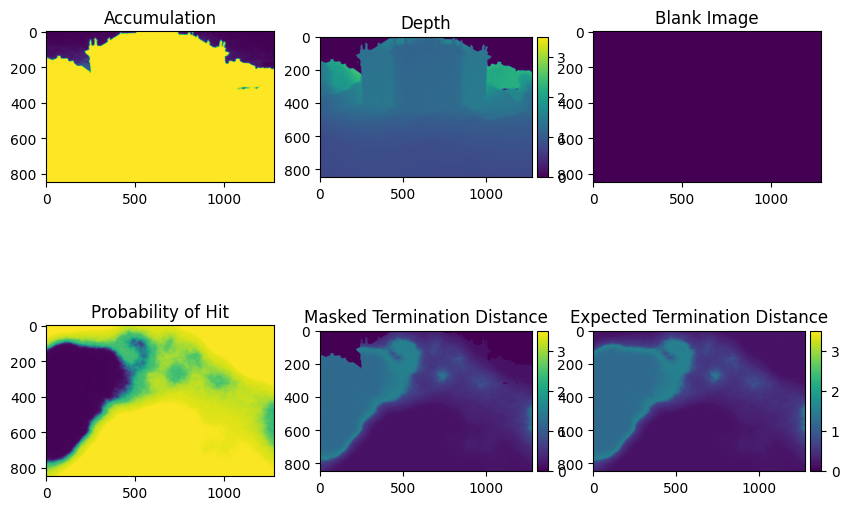

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# load data
data = torch.load("notebooks/ddf_test_data/single_viewpoint_data.pt")
H, W = data["H"], data["W"]

with torch.no_grad():
  accumulation = data['accumulation'].reshape(H, W).cpu().detach().numpy()
  depth = (data['termination_dist'] * (data['accumulation'] > 0.7).float()).reshape(H, W).cpu().detach().numpy()

  # plot everything in the same figure
  fig, ax = plt.subplots(2, 3, figsize=(10, 7))
  # first row is accumulation, rgb, depth
  im1 = ax[0, 0].imshow(accumulation, vmin=0, vmax=1)
  im2 = ax[0, 1].imshow(depth, vmin=0, vmax=3.5)
  # plot blank figure
  im3 = ax[0, 2].imshow(np.zeros((H, W)))
  

  # include colorbar next to im3 that is the same size as im3
  # include colorbars next to im2 and im3 that are same size as im2 and im3
  # Create a custom divider for the colorbar next to im2
  # Create a custom divider for the colorbar next to im3
  divider1 = make_axes_locatable(ax[0, 1])
  cax1 = divider1.append_axes("right", size="5%", pad=0.05)

  # Create the colorbars with the custom dividers
  fig.colorbar(im2, cax=cax1)

  # add titles to the first row
  ax[0, 0].set_title("Accumulation")
  ax[0, 1].set_title("Depth")
  ax[0, 2].set_title("Blank Image")

  positions = data['positions']
  directions = data['directions']

  # encoded_positions = position_encoding(positions) # [N, 16]
  # encoded_directions = direction_encoding(directions) # [N, 16]
  # model_input = torch.cat([positions, directions, encoded_positions, encoded_directions], dim=-1) # [N, 3 + 3 + 16 + 16] = [N, 38]

  model_input = torch.cat([positions, directions], dim=-1) # [N, 3 + 3] = [N, 6]

  output = ddf(model_input) # [N, 2]
  output = output.type(torch.float32)
  expected_termination_dist = torch.relu(output[..., 0]) # [N]
  probability_of_hit = torch.sigmoid(output[..., 1]) # We want a probability between 0 and 1 [N]

  # second row is probability of hit, blank image and expected termination distance
  im1 = ax[1, 0].imshow(probability_of_hit.reshape(H, W).cpu().detach().numpy(), vmin=0, vmax=1)
  im2 = ax[1, 1].imshow((expected_termination_dist * (data['accumulation'] > 0.7).float()).reshape(H, W).cpu().detach().numpy(), vmin=0, vmax=3.5)
  im3 = ax[1, 2].imshow(expected_termination_dist.reshape(H, W).cpu().detach().numpy(), vmin=0, vmax=3.5)

  # include colorbars next to im2 and im3 that are same size as im2 and im3
  # Create a custom divider for the colorbar next to im2
  divider2 = make_axes_locatable(ax[1, 1])
  cax2 = divider2.append_axes("right", size="5%", pad=0.05)

  # Create a custom divider for the colorbar next to im3
  divider3 = make_axes_locatable(ax[1, 2])
  cax3 = divider3.append_axes("right", size="5%", pad=0.05)

  # Create the colorbars with the custom dividers
  fig.colorbar(im2, cax=cax2)
  fig.colorbar(im3, cax=cax3)
  
  # add titles to the second row
  ax[1, 0].set_title("Probability of Hit")
  ax[1, 1].set_title("Masked Termination Distance")
  ax[1, 2].set_title("Expected Termination Distance")


Try including multi-view consistency loss

In [8]:
def multi_view_consitency(model, positions, directions, expected_termination_dist, number_of_comparisons, device):
  """We have an expected termination distance for each position. 
  We first select 'number_of_comparisons' other positions from positions.
  So we have [num_positions, num_comparisons, 3] new positions.
  Then we get the normalised direction between these new positions and the
  expected termination position. So we have [num_positions, num_comparisons, 3] directions.
  Then we get the expected termination distance for these new positions and normalised
  directions. We then expand the expected termination distance to [num_positions, num_comparisons]
  and return both the expected termination distance and the comparison expected termination distance.
  """

  # generate tensor or random indices shape [num_positions, num_comparisons] where each indices in num_comparisons
  # does not contain the original index
  num_positions = positions.shape[0]
  new_positions = random_points_on_unit_sphere(num_positions * number_of_comparisons, cartesian=True) # [num_positions * num_comparisons, 3]
  new_positions = new_positions.reshape(num_positions, number_of_comparisons, 3) # [num_positions, num_comparisons, 3]
  new_positions = new_positions.to(device)

  # get new directions between new positions and expected termination positions
  expected_termination_positions = positions + directions * expected_termination_dist.unsqueeze(1)
  expected_termination_dist = expected_termination_dist.unsqueeze(1).repeat(1, number_of_comparisons)
  expected_termination_positions = expected_termination_positions.unsqueeze(1).repeat(1, number_of_comparisons, 1)
  new_directions = new_positions - expected_termination_positions
  new_directions = new_directions / torch.norm(new_directions, dim=-1, keepdim=True)

  new_positions = new_positions.reshape(-1, 3)
  new_directions = new_directions.reshape(-1, 3)
  expected_termination_dist = expected_termination_dist.reshape(-1)

  # pass through model
  model_input = torch.cat([new_positions, new_directions], dim=-1)
  output = ddf(model_input)
  output = output.type(torch.float32)
  multi_view_expected_termination_dist = torch.relu(output[..., 0]) # [N]

  return expected_termination_dist, multi_view_expected_termination_dist



In [10]:
import wandb

# Initialize a new W&B run
wandb.init(project="ddf")

# setup optimizer and training loop
lr_start = 1e-4
lr_end = 1e-6
epochs = 15000
optim = torch.optim.Adam(ddf.parameters(), lr=lr_start)
# exponential learning rate decay
gamma = np.exp(np.log(lr_end / lr_start) / epochs)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=gamma)

sdf_loss = torch.nn.MSELoss()
hit_probability_loss = torch.nn.MSELoss()
expected_termination_loss = torch.nn.MSELoss()

dataset = DDFSDFDataset(1000, 1.0, model, repeat_position=True, device=device)

epochs_until_checkpoint = 1000

for i in tqdm.tqdm(range(epochs)):
    positions, directions, accumulation, termination_dist = dataset[i]
    positions = positions.to(device)
    directions = directions.to(device)
    accumulation = accumulation.to(device)
    termination_dist = termination_dist.to(device)

    # encoded_positions = position_encoding(positions) # [N, K]
    # encoded_directions = direction_encoding(directions) # [N, K]
    # model_input = torch.cat([positions, directions, encoded_positions, encoded_directions], dim=-1) # [N, K]

    model_input = torch.cat([positions, directions], dim=-1) # [N, 3 + 3] = [N, 6]

    output = ddf(model_input) # [N, 2]
    output = output.type(torch.float32)
    expected_termination_dist = torch.relu(output[..., 0]) # [N]
    probability_of_hit = torch.sigmoid(output[..., 1]) # We want a probability between 0 and 1 [N]

    # get sdf at termination outputted by the ddf
    sdf_at_termination = model.field.get_sdf_at_pos(positions + directions * expected_termination_dist.unsqueeze(-1)).squeeze() # [N]

    l1 = 3.0 * hit_probability_loss(probability_of_hit, accumulation)

    mask = (accumulation > 0.7).float() # only consider pixels that hit an object when estimating expected termination distance [N]

    l2 = 10.0 * sdf_loss(sdf_at_termination * mask, torch.zeros_like(sdf_at_termination))

    l3 = 3.0 * expected_termination_loss(expected_termination_dist * mask, termination_dist * mask)

    # use multi-view consistency to regularise the expected termination distance
    mv_original_termination_dist, mv_comparison_termination_dist = multi_view_consitency(ddf, positions, directions, expected_termination_dist, number_of_comparisons=1, device=device)

    # we want to penalise the model if the comparison termination distance is greater than the original termination distance, it doesn't matter if it is less
    mv_loss = torch.relu(mv_comparison_termination_dist - mv_original_termination_dist)
    l4 = 0.1 * mv_loss.mean()

    loss = l1 + l2 + l3 + l4
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()

    # save model to wandb folder
    if i + 1 % epochs_until_checkpoint == 0:
        torch.save(ddf.state_dict(), os.path.join(wandb.run.dir, f"ddf_step_{i}.pt"))

    # Log losses to W&B
    wandb.log({"hit_loss": l1.item(), "sdf_loss": l2.item(), "term_loss": l3.item(), "mv_loss": l4.item(), "total_loss": loss.item()})

wandb.finish()



hit_loss,█▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mv_loss,█▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁
sdf_loss,▄▃▂▁▁▁▂▂█▅▅▅▃▃▄▄▃▂▃▂▃▂▃▂▃▂▃▂▂▃▃▂▂▂▃▂▃▂▂▂
term_loss,█▄▂▁▂▁▂▁▃▄▂▃▂▁▂▂▄▂▂▂▁▁▁▂▁▁▂▁▁▁▁▂▂▁▁▁▁▁▂▁
total_loss,█▃▁▁▁▁▁▁▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
hit_loss,0.00455
mv_loss,7e-05
sdf_loss,0.00156
term_loss,0.00418
total_loss,0.01037


  5%|▌         | 799/15000 [01:18<23:20, 10.14it/s]


KeyboardInterrupt: 

In [24]:
# load model from latest wandb checkpoint
step = 1000
wandb_dir = os.path.join("/workspaces/sdfstudio/wandb/latest-run/files", f"ddf_step_{step}.pt")
ddf.load_state_dict(torch.load(wandb_dir))

torch.Size([5, 3])